In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use("default")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

DATA_PATH = "datasets/summit_dbe_processed_with_time.parquet"
df = pd.read_parquet(DATA_PATH)

In [ ]:
#convert timestamp and extract hour
df = df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])

df["hour"] = df["timestamp"].dt.hour

print(df[["timestamp", "hour"]].head())

                  timestamp  hour
0 2020-10-05 15:22:36+00:00    15
1 2020-10-05 06:41:43+00:00     6
2 2020-10-05 02:35:48+00:00     2
3 2020-10-05 20:20:53+00:00    20
4 2020-10-05 02:14:04+00:00     2


In [5]:
#compute failure rate by hour
hourly = df.groupby("hour")["is_failure"].agg(["count", "sum"])
hourly["failure_rate"] = hourly["sum"] / hourly["count"]

print(hourly)

      count   sum  failure_rate
hour                           
0      2063  18.0      0.008725
1      2122  22.0      0.010368
2      2065  11.0      0.005327
3      2164  13.0      0.006007
4      2273  10.0      0.004399
5      2052  16.0      0.007797
6      2071  12.0      0.005794
7      2101   8.0      0.003808
8      2024   5.0      0.002470
9      2042  11.0      0.005387
10     2114   8.0      0.003784
11     2078   7.0      0.003369
12     2114   9.0      0.004257
13     2078  14.0      0.006737
14     2056  15.0      0.007296
15     2217  16.0      0.007217
16     2086  17.0      0.008150
17     2103  11.0      0.005231
18     2058  12.0      0.005831
19     2106  12.0      0.005698
20     2082  13.0      0.006244
21     2064  18.0      0.008721
22     2023  10.0      0.004943
23     2103   7.0      0.003329


In [6]:
#compare telemetry spikes during peak failure hours
peak_hours = hourly["failure_rate"].sort_values(ascending=False).head(3).index.tolist()
print("Peak failure hours:", peak_hours)

peak_rows = df[df["hour"].isin(peak_hours)]
normal_rows = df[~df["hour"].isin(peak_hours)]

cols_to_check = [
    "power_mean_1min",
    "core_temp_mean_1min",
    "mem_temp_mean_1min",
    "power_fluct_1h"
]

peak_summary = peak_rows[cols_to_check].describe()
normal_summary = normal_rows[cols_to_check].describe()

print("Peak hours telemetry summary:")
print(peak_summary)

print("\nNon-peak hours telemetry summary:")
print(normal_summary)

Peak failure hours: [1, 0, 21]
Peak hours telemetry summary:
       power_mean_1min  core_temp_mean_1min  mem_temp_mean_1min  power_fluct_1h
count      6249.000000          6249.000000         6249.000000     6249.000000
mean         58.716664            33.077658           31.320527       11.655240
std          53.013580             4.466906            5.142950       19.453737
min           3.000000            25.827586           23.000000        0.000000
25%          32.679245            31.000000           29.000000        0.092729
50%          47.883333            32.000000           30.000000        1.970412
75%          65.433333            33.294118           31.038462       15.107807
max         309.944444            86.000000           83.000000      122.578503

Non-peak hours telemetry summary:
       power_mean_1min  core_temp_mean_1min  mem_temp_mean_1min  power_fluct_1h
count     44010.000000         44010.000000        44010.000000    44010.000000
mean         59.558947  

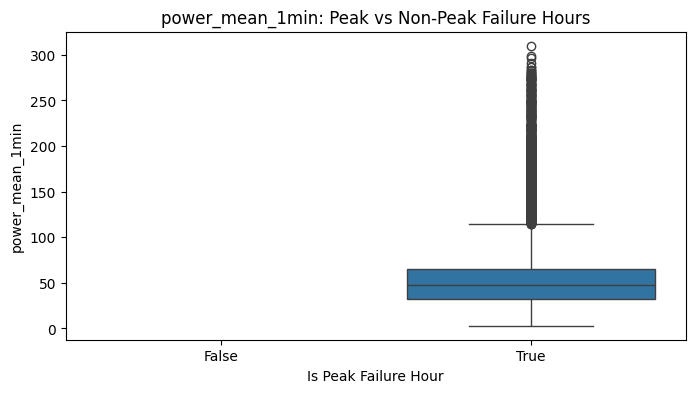

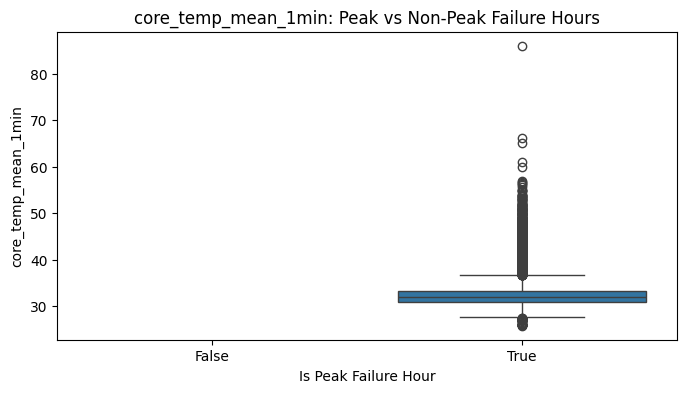

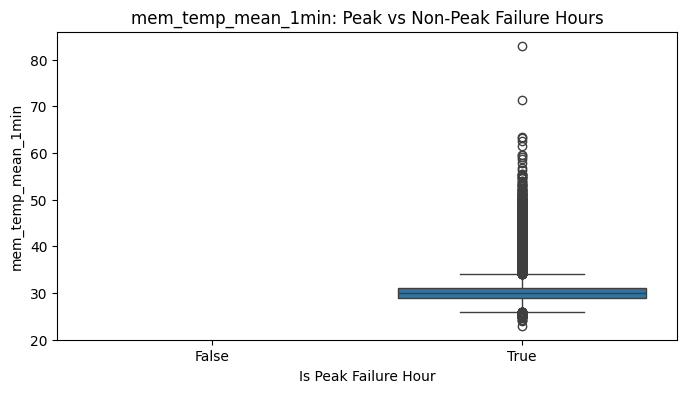

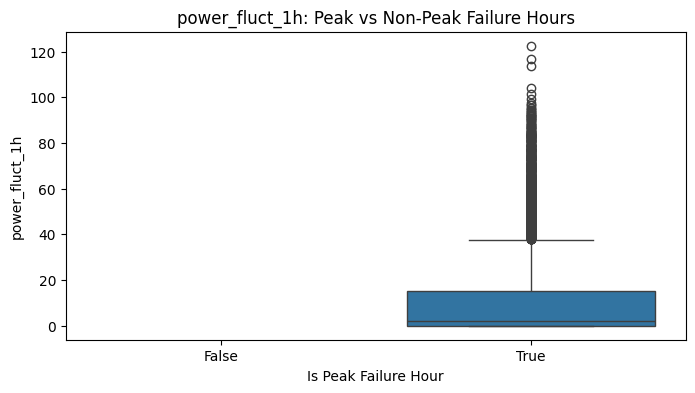

In [7]:
#Plot telemetry differences between peak vs non-peak hours
for col in cols_to_check:
    plt.figure(figsize=(8,4))
    sns.boxplot(
        data=df[df["hour"].isin(peak_hours + [peak_hours[0]])], # trick to keep categories aligned
        x=df["hour"].isin(peak_hours),
        y=col
    )
    plt.xlabel("Is Peak Failure Hour")
    plt.ylabel(col)
    plt.title(f"{col}: Peak vs Non-Peak Failure Hours")
    plt.show()